# Why Differentiable Spectral Modeling?

Last Update: January 19th (2025) Hajime Kawahara

[ExoJAX](https://github.com/HajimeKawahara/exojax) is a differentiable spectral model written in [JAX](https://jax.readthedocs.io/en/latest/). Here, we aim to provide a brief introduction to what can be achieved with differentiable models for users who may not be familiar with [Differentiable Programming](https://arxiv.org/abs/2403.14606) (DP).

Here, as the simplest example of a spectrum, we use an absorption spectrum consisting of a single hypothetical absorption line of a molecule X.
This absorption line follows a Voigt profile, characterized by a line profile centered at `nu0` , determined by the temperature-dependent core width `beta` and the temperature- and pressure-dependent wing width  `gamma` . The cross-section is given as follows:

Text(0, 0.5, 'cross section (cm$^2$)')

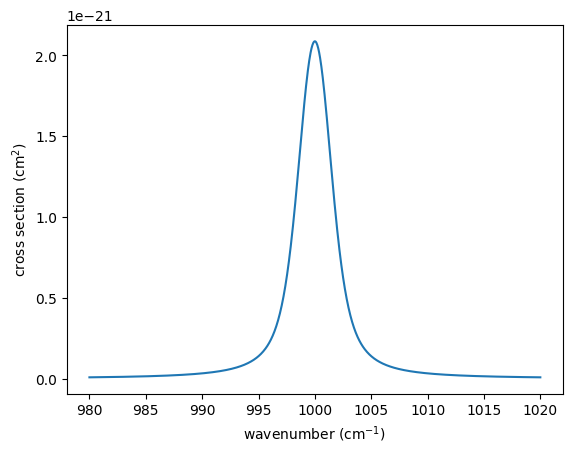

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from exojax.spec import voigt

logbeta = 1.0
gamma = 1.0
line_strength = 1.e-20 #cm2
nu0 = 1000.0
nu_grid = jnp.linspace(nu0-20,nu0+20,1000)


sigma = line_strength*voigt(nu_grid - nu0,logbeta,gamma)

plt.plot(nu_grid, sigma) 
plt.xlabel("wavenumber (cm$^{-1}$)")
plt.ylabel("cross section (cm$^2$)")

When light with a flat spectrum $ f_0 $ passes through a region filled with molecule X at a number density $ n $ over a path length $ L $, the transmitted spectrum is given by $ f_0 \exp(-\tau_\nu) $, where the optical depth $ \tau_\nu = n L \sigma_\nu $. Using the column density $ N = n L $, this can be expressed as 
$f_\nu = f_0 \exp{(-N \sigma_\nu )} $.

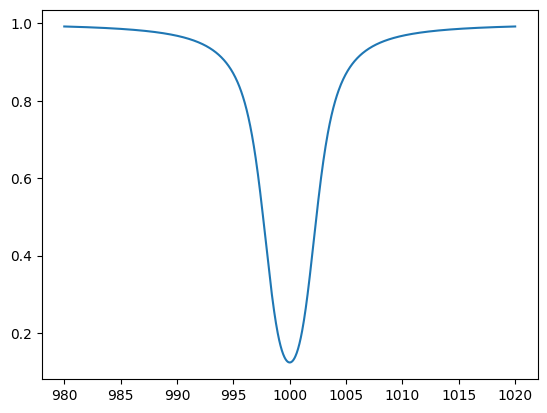

In [2]:
f0 = jnp.ones_like(nu_grid)
n = 1.e17
L = 1.e4
logN = n*L
f = f0*jnp.exp(-sigma*logN)

plt.plot(nu_grid, f)
plt.show()

Observed spectra always contain statistical errors. Here, we simplify by assuming wavenumber-independent Gaussian noise and add noise accordingly.

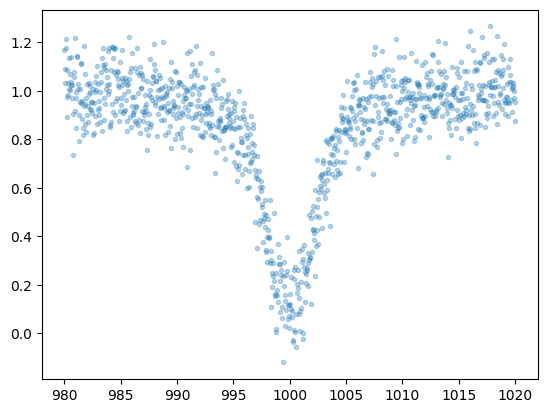

In [14]:
import numpy as np
sigma_noise = 0.1
np.random.seed(0)
fobs = f + np.random.normal(0.0,sigma_noise,len(f))
plt.plot(nu_grid, fobs, ".",alpha=0.3)
plt.show()

Now, what can a differentiable spectral model do with this observed spectrum? Let’s first assume that `gamma` is known and focus on estimating `N` and `beta`.

In [4]:
def fmodel(N,beta):
    gamma=1.0
    nu0 = 1000.0
    sigma = line_strength*voigt(nu_grid - nu0,beta,gamma)
    f = f0*jnp.exp(-sigma*N)
    return f

## gradient-based optimization

In a differentiable spectral model, gradient-based optimization is possible. Specifically, when $ \chi^2 $ is expressed as a function of `N` (normalized by 1e21) and `beta`, we can compute the gradients of $ \chi^2 $ with respect to `N` and `beta`. This allows us to determine the next step that minimizes $\chi^2 $, following the same principle as descending along the slope of a hill toward the valley bottom. 

In [5]:
def chi2_fmodel(params):
    """differentiable chi2 function
    Args:
        params: logN (float), log surface density, logbeta (float), log beta

    Returns:
        float: chi2
    """
    logN, logbeta = params
    f = fmodel(10**logN,10**logbeta)
    return jnp.sum((f-fobs)**2/sigma_noise**2)

Here, let’s first check the distribution of $\chi^2$. However, this is only feasible because the parameter space is two-dimensional in this case. In general, such an approach would be challenging.

Text(0, 0.5, 'log beta')

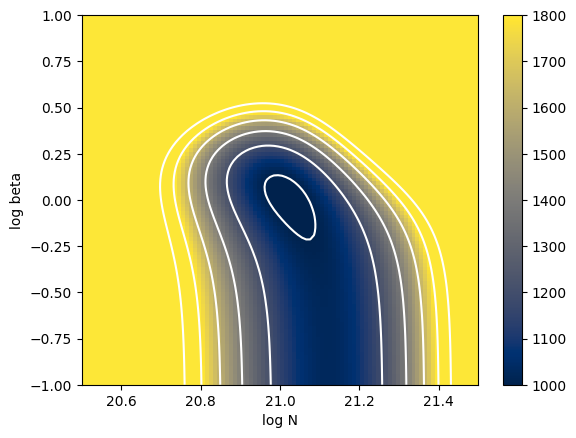

In [6]:
Narray = jnp.linspace(20.5, 21.5, 100)
betaarray = jnp.linspace(-1, 1, 100)


# unpacks parameters
def chi2_fmodel_unpackpar(logN, logbeta):
    return chi2_fmodel(jnp.array([logN, logbeta]))


from jax import vmap

vmapchi2 = vmap(vmap(chi2_fmodel_unpackpar, (0, None), 0), (None, 0), 0)
chi2arr = vmapchi2(Narray, betaarray)

a = plt.imshow(
    chi2arr[::-1, :],
    extent=(Narray[0], Narray[-1], betaarray[0], betaarray[-1]),
    aspect="auto",
    cmap="cividis",
    vmin=1000,
    vmax=1800,
)
cb = plt.colorbar(a)
levels = [1000, 1200, 1400, 1600, 1800, 2000]
plt.contour(Narray, betaarray, chi2arr, levels=levels, colors="white")
plt.xlabel("log N")
plt.ylabel("log beta")

The key point here is that the $ \chi^2 $ defined using a differentiable spectral model is itself differentiable with respect to the parameters.

In [7]:
from jax import grad
dchi2 = grad(chi2_fmodel)
logNinit = 20.75
logbetainit = 0.5
params_init = jnp.array([logNinit,logbetainit])
dchi2(params_init)

Array([-5780.8774,  4569.641 ], dtype=float32)

Let’s perform gradient-based optimization using the (differentiable) $\chi^2$ as the cost function. 
The simplest gradient optimization method, steepest gradient descent, starts from an initial value and updates the parameters in the negative gradient direction. 
The step size $\eta$ determines the magnitude of each update step.

${\bf p}_n = {\bf p}_{n-1} - \eta \left( \frac{ d {\bf \chi^2}}{d {\bf p}} \right)_{n-1}  $

In [8]:
eta = 1.e-5
Nstep = 30 
params = jnp.copy(params_init)
trajectory = []
for i in range(Nstep):
    trajectory.append(params)
    params = params - eta*dchi2(params)

trajectory = jnp.array(trajectory)
    

Let’s plot the trajectory of parameter updates using the steepest gradient descent method. You can observe the parameters being updated toward the local minimum. It’s interesting to experiment with different values of $ \eta $. If $ \eta $ is too large, the updates overshoot and oscillate across the valley, while if it’s too small, the descent toward the minimum becomes very slow. However, with an appropriate step size, the optimization proceeds efficiently.

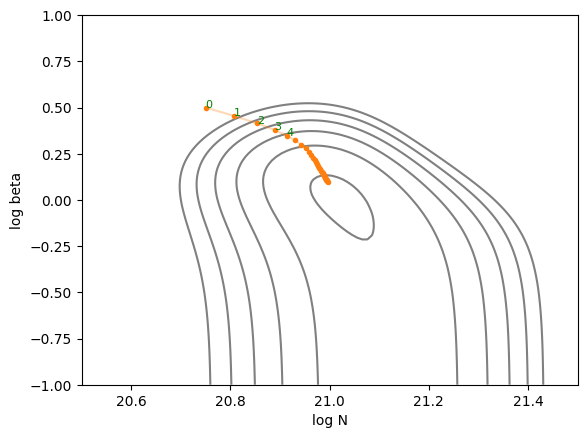

In [9]:
def plot_trajectory(trajectory):
    plt.contour(
    Narray,
    betaarray,
    chi2arr,
    levels=levels,
    colors="gray",
)
    plt.xlabel("log N")
    plt.ylabel("log beta")
    plt.plot(trajectory[:, 0], trajectory[:, 1], ".", color="C1")
    plt.plot(trajectory[:, 0], trajectory[:, 1], color="C1", alpha=0.3)
    for i in range(5):
        plt.text(trajectory[i, 0], trajectory[i, 1], str(i), fontsize=8, color="green")

plot_trajectory(trajectory)

In JAX, [various gradient optimization techniques](https://optax.readthedocs.io/en/latest/api/optimizers.html) can be easily implemented using [Optax](https://optax.readthedocs.io/en/latest/index.html). 
Here, we’ll use one of the commonly used optimizers, ADAM, to find the parameters that minimize (or more precisely, locally minimize) $ \chi^2 $.

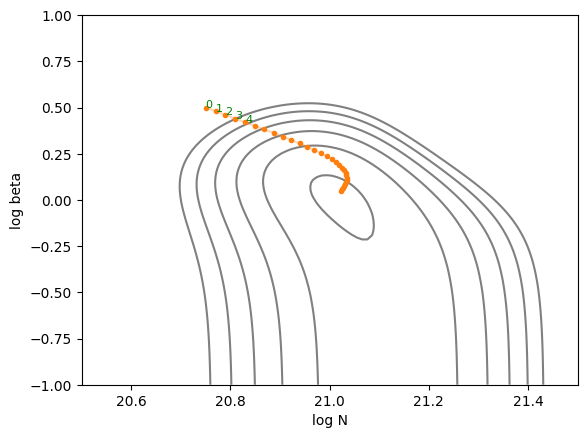

In [10]:
import optax

solver = optax.adam(learning_rate=0.02)
opt_state = solver.init(params_init)
Nstep = 30
params = jnp.copy(params_init)

trajectory_adam = []
for i in range(Nstep):
    trajectory_adam.append(params)
    grad = dchi2(params)
    updates, opt_state = solver.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)

plot_trajectory(jnp.array(trajectory_adam))    

Using the updated parameters to predict the spectrum results in the following:

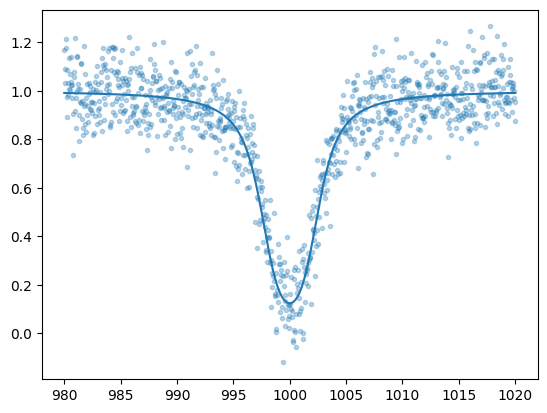

In [13]:

plt.plot(nu_grid, fobs, ".", alpha=0.3)
plt.plot(nu_grid, fmodel(10**params[0],10**params[1]), color="C0")
plt.show()